In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
import wandb

import torch
from torch import nn
from torchvision import models
import torch.optim as optim

from dataset import get_dataloaders, get_tiles_datasets
from utils import seed_everything
from trainer import Trainer

# Params
Image.MAX_IMAGE_PIXELS = 1e11
CFG = {
    'seed': 42,
    'cv_fold': 5,
    'base_model': 'efficientnet_b1',   # resnet18/34/50, efficientnet_b0/b1/b2/b3/b4
    'img_size': 512,
    'batch_size': 32,
    'freeze_epochs': 1,
    'epochs': 5,
    'base_lr': 1e-4,
    'affine_degrees': 0,
    'affine_translate': None,
    'affine_scale': None,
    'dataloader_num_workers': 8,
    'scheduler_step_size': 2,
    'img_color_mean': [0.8708488980328596, 0.75677901508938, 0.8545134911215124],
    'img_color_std': [0.08086288591996027, 0.11553960008706814, 0.06914169213328555],
    'tile_num': 32,
    'optimizer': 'AdamW',
    'scheduler': 'StepLR',
    'lr_gamma': 0.1,
    'sgd_momentum': 0.9,
    'tile_set': 'train_tiles_2048_p25_drop80_outl80_v4'
}
tags=['torch', 'tiles', 'cv']
notes = ''
plot_samples = False

# Wandb
wandb.login(key='1b0401db7513303bdea77fb070097f9d2850cf3b')
run = wandb.init(project='kaggle-ubc-ocean', config=CFG, tags=tags, notes=notes)

# Label encoder/decoder
encode = {'HGSC': 0, 'LGSC': 1, 'EC': 2, 'CC': 3, 'MC': 4}
decode = {v: k for k, v in encode.items()}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_image_dir = os.path.join(results_dir, CFG['tile_set'])
train_csv = '{}_sample{}.csv'.format(CFG['tile_set'], CFG['tile_num'])

# Seed
seed_everything(CFG['seed'])

# Load data
df = pd.read_csv(os.path.join(results_dir, train_csv))
df['label'] = df.loc[:,'label'].map(encode)

# Functions
def train_model(CFG, train_image_dir, df_train, df_validation, encode, wandb_log=False):
    # Data loaders
    datasets = get_tiles_datasets(CFG, train_image_dir, df_train, df_validation)
    dataloaders = get_dataloaders(CFG, datasets)

    # Model definition
    model = models.get_model(CFG['base_model'], weights='DEFAULT').to(device)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last fully-connected layer
    if CFG['base_model'].startswith('resnet'):
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(encode)).to(device)
    elif CFG['base_model'].startswith('efficientnet'):
        model.classifier = nn.Linear(in_features=model.classifier[1].in_features, out_features=len(encode)).to(device)
    
    # Loss function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    if CFG['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=CFG['base_lr'], momentum=CFG['sgd_momentum'])
    elif CFG['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=CFG['base_lr'])
    elif CFG['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=CFG['base_lr'])
    
    # Scheduler
    if CFG['scheduler'] == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=CFG['scheduler_step_size'], gamma=CFG['lr_gamma'], verbose=True)
    elif CFG['scheduler'] == 'CyclicLR':
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=CFG['base_lr'], max_lr=CFG['base_lr']*5,
                                                step_size_up=5, cycle_momentum=False, mode='triangular2', verbose=True)
    elif CFG['scheduler'] == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs']+CFG['freeze_epochs'], verbose=True)
    elif CFG['scheduler'] == 'OneCycleLR':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG['base_lr'], total_steps=CFG['epochs']+CFG['freeze_epochs'], verbose=True)

    # Training
    trainer = Trainer(model, dataloaders, loss_fn, optimizer, scheduler, device, metric='balanced_accuracy', wandb_log=wandb_log)
    model, _ = trainer.train_epochs(num_epochs=CFG['freeze_epochs'])
    trainer.unfreeze()
    model, balanced_acc = trainer.train_epochs(num_epochs=CFG['epochs'])
    return model, balanced_acc

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: naraiadam88. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/latlab/.netrc


In [2]:
# Show training data
if plot_samples:
    dataloaders = get_dataloaders(CFG, get_tiles_datasets(CFG, train_image_dir, df, df))
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloaders['train']):
            plt.figure(figsize=(np.ceil(len(X)/2), 12))
            for i in range(len(X)):
                plt.subplot(int(np.ceil(len(X)/6)), 6, i+1)
                img_data = X[i].permute(1, 2, 0).cpu().numpy()
                plt.imshow(img_data)
                plt.title(f'{decode[y[i].item()]}')
            if batch >= 1:
                break

In [3]:
skf = StratifiedGroupKFold(n_splits=CFG['cv_fold'], random_state=CFG['seed'], shuffle=True)
balanced_acc_list = []
for cv, (train_index, valid_index) in enumerate(skf.split(X=np.zeros(len(df['label'])), y=df['label'], groups=df['orig_image_id'])):
    print(f"Cross-validation fold {cv+1}/{CFG['cv_fold']}")
    df_train = df.iloc[train_index]
    df_validation = df.iloc[valid_index]
    run_name = f'{run.name}-cv{cv+1}'
    model, balanced_acc = train_model(CFG, train_image_dir, df_train, df_validation, encode)
    balanced_acc_list.append(balanced_acc)
    torch.save(model.state_dict(), os.path.join(results_dir, 'models', f'ubc-ocean-{run_name}.pt'))
    wandb.log({f'balanced_acc_cv{cv+1}': balanced_acc})
wandb.log({f'mean_balanced_acc': np.mean(balanced_acc_list)})
wandb.finish()

Cross-validation fold 1/5
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1/1
----------


100%|██████████| 198/198 [00:28<00:00,  6.91it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 1.2175, test loss: 1.1695, balanced_accuracy: 0.5728

Training complete in 2m 33s
Final balanced_accuracy: 0.572794

Epoch 1/5
----------


100%|██████████| 198/198 [00:22<00:00,  8.70it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.4369, test loss: 1.0263, balanced_accuracy: 0.6872

Epoch 2/5
----------


100%|██████████| 198/198 [00:22<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1876, test loss: 0.9339, balanced_accuracy: 0.7287

Epoch 3/5
----------


100%|██████████| 198/198 [00:22<00:00,  8.71it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1494, test loss: 0.9212, balanced_accuracy: 0.7406

Epoch 4/5
----------


100%|██████████| 198/198 [00:22<00:00,  8.71it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1246, test loss: 0.9330, balanced_accuracy: 0.7408

Epoch 5/5
----------


100%|██████████| 198/198 [00:22<00:00,  8.64it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
train loss: 0.1216, test loss: 0.9274, balanced_accuracy: 0.7465

Training complete in 24m 14s
Final balanced_accuracy: 0.746511

Cross-validation fold 2/5
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1/1
----------


100%|██████████| 211/211 [00:24<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 1.2446, test loss: 1.0702, balanced_accuracy: 0.6374

Training complete in 2m 3s
Final balanced_accuracy: 0.637361

Epoch 1/5
----------


100%|██████████| 211/211 [00:24<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.4479, test loss: 1.1227, balanced_accuracy: 0.6926

Epoch 2/5
----------


100%|██████████| 211/211 [00:24<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1880, test loss: 0.9603, balanced_accuracy: 0.7586

Epoch 3/5
----------


100%|██████████| 211/211 [00:24<00:00,  8.70it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1475, test loss: 1.0337, balanced_accuracy: 0.7521

Epoch 4/5
----------


100%|██████████| 211/211 [00:24<00:00,  8.70it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1231, test loss: 1.0468, balanced_accuracy: 0.7482

Epoch 5/5
----------


100%|██████████| 211/211 [00:24<00:00,  8.70it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
train loss: 0.1220, test loss: 1.0338, balanced_accuracy: 0.7505

Training complete in 23m 60s
Final balanced_accuracy: 0.750521

Cross-validation fold 3/5
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1/1
----------


100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 1.2359, test loss: 1.1091, balanced_accuracy: 0.5908

Training complete in 2m 3s
Final balanced_accuracy: 0.590770

Epoch 1/5
----------


100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.4366, test loss: 0.9243, balanced_accuracy: 0.7051

Epoch 2/5
----------


100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1858, test loss: 0.9380, balanced_accuracy: 0.7316

Epoch 3/5
----------


100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1479, test loss: 0.9197, balanced_accuracy: 0.7485

Epoch 4/5
----------


100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1233, test loss: 0.9541, balanced_accuracy: 0.7472

Epoch 5/5
----------


100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
train loss: 0.1239, test loss: 0.9135, balanced_accuracy: 0.7538

Training complete in 24m 18s
Final balanced_accuracy: 0.753802

Cross-validation fold 4/5
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1/1
----------


100%|██████████| 201/201 [00:23<00:00,  8.68it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 1.2286, test loss: 1.1377, balanced_accuracy: 0.5535

Training complete in 2m 3s
Final balanced_accuracy: 0.553520

Epoch 1/5
----------


100%|██████████| 201/201 [00:23<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.4336, test loss: 0.9539, balanced_accuracy: 0.7261

Epoch 2/5
----------


100%|██████████| 201/201 [00:23<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1796, test loss: 0.8591, balanced_accuracy: 0.7436

Epoch 3/5
----------


100%|██████████| 201/201 [00:23<00:00,  8.68it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1399, test loss: 0.8616, balanced_accuracy: 0.7526

Epoch 4/5
----------


100%|██████████| 201/201 [00:23<00:00,  8.68it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1169, test loss: 0.8915, balanced_accuracy: 0.7522

Epoch 5/5
----------


100%|██████████| 201/201 [00:23<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
train loss: 0.1142, test loss: 0.9217, balanced_accuracy: 0.7462

Training complete in 24m 12s
Final balanced_accuracy: 0.746249

Cross-validation fold 5/5
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1/1
----------


100%|██████████| 205/205 [00:23<00:00,  8.68it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 1.2105, test loss: 1.2403, balanced_accuracy: 0.4643

Training complete in 2m 3s
Final balanced_accuracy: 0.464318

Epoch 1/5
----------


100%|██████████| 205/205 [00:23<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.4343, test loss: 0.9862, balanced_accuracy: 0.6964

Epoch 2/5
----------


100%|██████████| 205/205 [00:23<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1780, test loss: 1.0001, balanced_accuracy: 0.7149

Epoch 3/5
----------


100%|██████████| 205/205 [00:23<00:00,  8.67it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1412, test loss: 1.0347, balanced_accuracy: 0.7217

Epoch 4/5
----------


100%|██████████| 205/205 [00:23<00:00,  8.69it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1198, test loss: 1.0450, balanced_accuracy: 0.7239

Epoch 5/5
----------


100%|██████████| 205/205 [00:23<00:00,  8.70it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
train loss: 0.1143, test loss: 1.0563, balanced_accuracy: 0.7204

Training complete in 24m 8s
Final balanced_accuracy: 0.720419



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


balanced_acc_cv1,▁
balanced_acc_cv2,▁
balanced_acc_cv3,▁
balanced_acc_cv4,▁
balanced_acc_cv5,▁
mean_balanced_acc,▁
balanced_acc_cv1,0.74651
balanced_acc_cv2,0.75052
balanced_acc_cv3,0.7538
balanced_acc_cv4,0.74625
balanced_acc_cv5,0.72042


In [4]:
# Final training on all data
final_model, _ = train_model(CFG, train_image_dir, df, df, encode, wandb_log=False)
torch.save(final_model.state_dict(), os.path.join(results_dir, 'models', f'ubc-ocean-{run.name}.pt'))

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1/1
----------


100%|██████████| 1010/1010 [01:53<00:00,  8.91it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 1.2011, test loss: 1.0271, balanced_accuracy: 0.6100

Training complete in 3m 57s
Final balanced_accuracy: 0.610007

Epoch 1/5
----------


100%|██████████| 1010/1010 [01:53<00:00,  8.91it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.4381, test loss: 0.2199, balanced_accuracy: 0.9213

Epoch 2/5
----------


100%|██████████| 1010/1010 [01:53<00:00,  8.92it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.1872, test loss: 0.1082, balanced_accuracy: 0.9623

Epoch 3/5
----------


100%|██████████| 1010/1010 [01:53<00:00,  8.91it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1482, test loss: 0.0831, balanced_accuracy: 0.9722

Epoch 4/5
----------


100%|██████████| 1010/1010 [01:53<00:00,  8.91it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.1235, test loss: 0.0862, balanced_accuracy: 0.9720

Epoch 5/5
----------


100%|██████████| 1010/1010 [01:53<00:00,  8.92it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
train loss: 0.1196, test loss: 0.0777, balanced_accuracy: 0.9741

Training complete in 37m 12s
Final balanced_accuracy: 0.974130



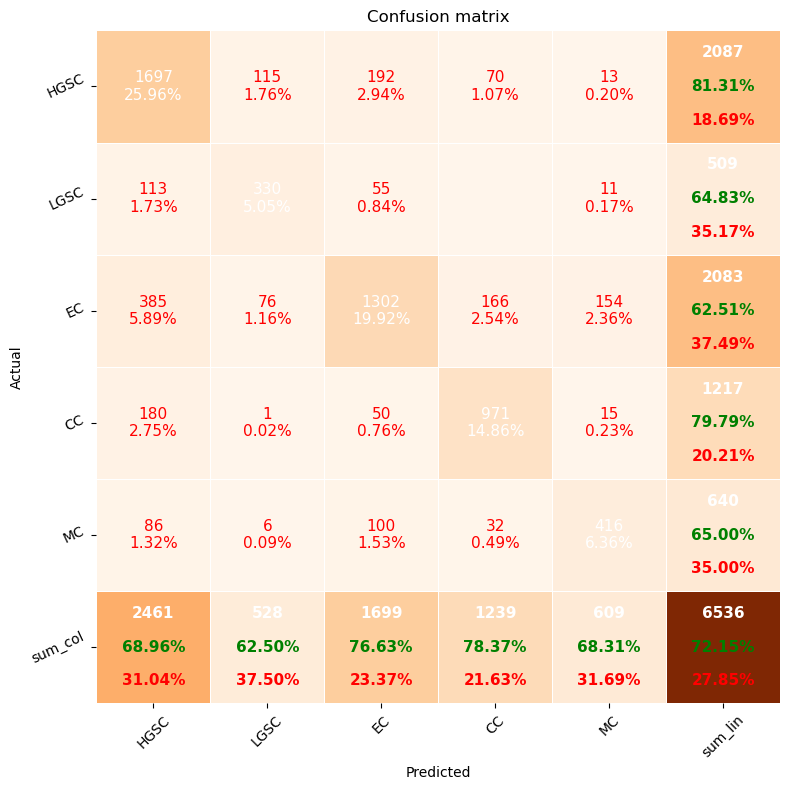

In [5]:
# Confusion matrix
import warnings
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
loss_fn = nn.CrossEntropyLoss(reduction='none')
datasets = get_tiles_datasets(CFG, train_image_dir, df_train, df_validation)
dataloaders = get_dataloaders(CFG, datasets)
y_list = []
pred_list = []
loss_list = []
metric = 0
with torch.no_grad():
    for X, y in dataloaders['validation']:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, y)
        y_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())
        loss_list.append(loss.cpu().numpy())
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=UserWarning)
            metric += balanced_accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
metric /= len(dataloaders['validation'])
y_list = np.concatenate(y_list)
pred_list = np.concatenate(pred_list)
loss_list = np.concatenate(loss_list)

from ext.pretty_confusion_matrix import pp_matrix
cm = confusion_matrix(y_list, pred_list)
df_cm = pd.DataFrame(cm, index=encode.keys(), columns=encode.keys())
pp_matrix(df_cm, pred_val_axis='x', cmap='Oranges', figsize=(8, 8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

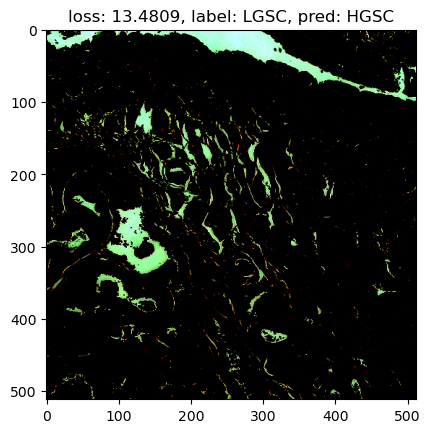

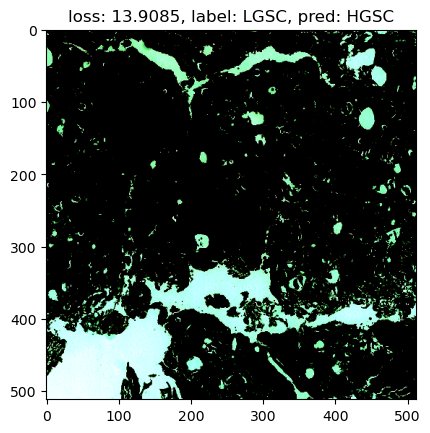

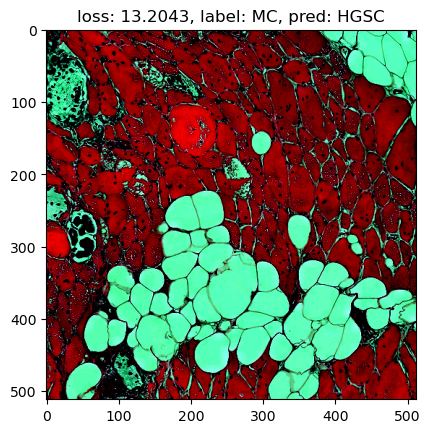

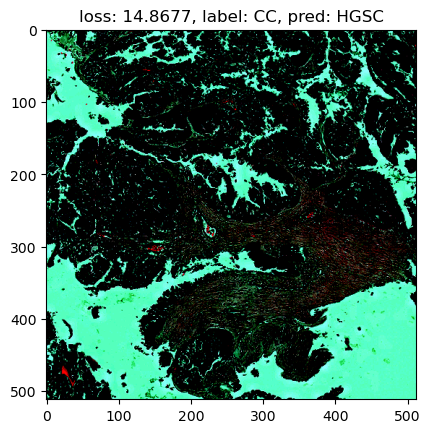

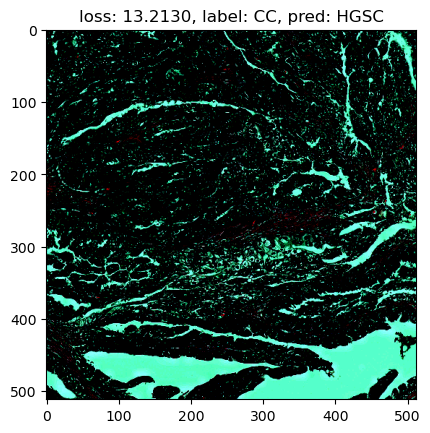

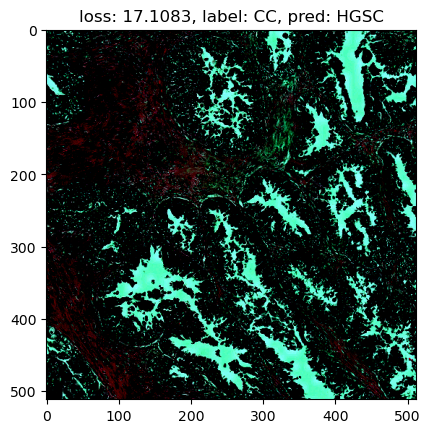

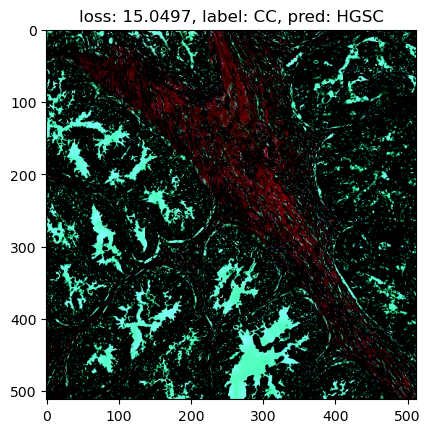

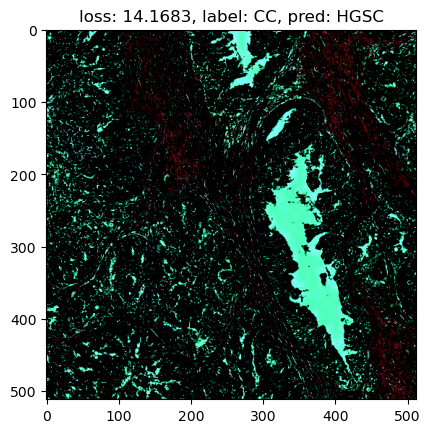

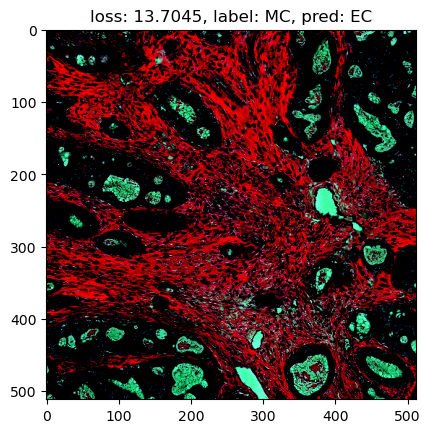

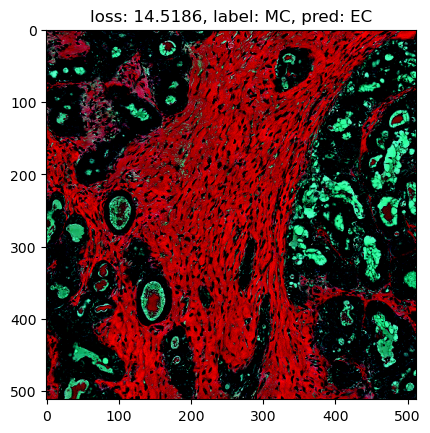

In [6]:
# Top k losses
k = 10
topk_loss_idx = list(loss_list.argsort()[-k:])
with torch.no_grad():
    for b, (X, y) in enumerate(dataloaders['validation']):
        for bi in range(len(X)):
            i = b * CFG['batch_size'] + bi
            if i not in topk_loss_idx:
                continue
            plt.figure()
            plt.imshow(X[bi].permute(1, 2, 0))
            plt.title(f'loss: {loss_list[i]:.4f}, label: {decode[y_list[i]]}, pred: {decode[pred_list[i]]}')